In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from torchvision.transforms import functional as F
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

import numpy as np
import random

In [2]:
SEED = 154

np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, x_dir, y_dir, transform=None, image_size=(256, 256)):
        self.x_dir = x_dir
        self.y_dir = y_dir
        self.transform = transform
        self.image_size = image_size
        self.x_images = []
        self.y_images = []
        self.classes = sorted(os.listdir(x_dir))
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}
        
        for cls_name in self.classes:
            cls_x_dir = os.path.join(x_dir, cls_name)
            cls_y_dir = os.path.join(y_dir, cls_name)
            x_image_names = os.listdir(cls_x_dir)
            y_image_names = os.listdir(cls_y_dir)
            x_image_names.sort()
            y_image_names.sort()
            
            for x_image_name, y_image_name in zip(x_image_names, y_image_names):
                x_image_path = os.path.join(cls_x_dir, x_image_name)
                y_image_path = os.path.join(cls_y_dir, y_image_name)
                label = self.class_to_idx[cls_name]
                self.x_images.append((x_image_path, label))
                self.y_images.append((y_image_path, label))
    
    def __len__(self):
        return len(self.x_images)
    
    def resize_and_pad(self, image):
        image = F.resize(image, self.image_size, interpolation=transforms.InterpolationMode.BILINEAR)
        width, height = image.size
        if width != self.image_size[0] or height != self.image_size[1]:
            pad_right = max(0, self.image_size[0] - width)
            pad_bottom = max(0, self.image_size[1] - height)
            image = F.pad(image, padding=[0, 0, pad_right, pad_bottom], fill=0)
        return image
    
    def __getitem__(self, idx):
        x_image_path, _ = self.x_images[idx]
        y_image_path, _ = self.y_images[idx]
        
        x_image = Image.open(x_image_path).convert('RGB')
        y_image = Image.open(y_image_path).convert('L')
        
        x_image = self.resize_and_pad(x_image)
        y_image = self.resize_and_pad(y_image)
        
        x_image = transforms.ToTensor()(x_image)
        y_image = transforms.ToTensor()(y_image)
        y_image = (y_image > 0).float()
        
        if self.transform:
            x_image = self.transform(x_image)
        
        return x_image, y_image

In [4]:
class EarlyStopping:
    def __init__(self, tolerance=10, min_delta=0.01):
        self.tolerance = tolerance
        self.min_delta = min_delta
        self.min_loss = float('inf')
        self.counter = 0
        self.early_stop = False
        self.model_dict = None
        self.optim_dict = None
        self.epoch = -1
        
    def __call__(self, val_loss, model_dict, optim_dict, epoch):
        if (self.min_loss - val_loss) > self.min_delta:
            self.counter = 0
            self.min_loss = val_loss
            self.model_dict = model_dict
            self.optim_dict = optim_dict
            self.epoch = epoch
        else:
            self.counter += 1
            if self.counter >= self.tolerance:
                self.early_stop = True

In [5]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.SiLU(inplace=True),
            
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.SiLU(inplace=True)
        )
        
    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()
        
        self.down1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        
        self.down2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        
        self.down3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        
        self.down4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)
        
        self.middle = DoubleConv(512, 1024)
        
        self.up4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.up_conv4 = DoubleConv(1024, 512)
        
        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.up_conv3 = DoubleConv(512, 256)
        
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.up_conv2 = DoubleConv(256, 128)
        
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.up_conv1 = DoubleConv(128, 64)
        
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)
        
    def forward(self, x):
        x1 = self.down1(x)
        x2 = self.pool1(x1)
        
        x3 = self.down2(x2)
        x4 = self.pool2(x3)
        
        x5 = self.down3(x4)
        x6 = self.pool3(x5)
        
        x7 = self.down4(x6)
        x8 = self.pool4(x7)
        
        x9 = self.middle(x8)
        
        x = self.up4(x9)
        x = torch.cat([x7, x], dim=1)
        x = self.up_conv4(x)
        
        x = self.up3(x)
        x = torch.cat([x5, x], dim=1)
        x = self.up_conv3(x)
        
        x = self.up2(x)
        x = torch.cat([x3, x], dim=1)
        x = self.up_conv2(x)
        
        x = self.up1(x)
        x = torch.cat([x1, x], dim=1)
        x = self.up_conv1(x)
        
        x = self.final_conv(x)
        return x

In [6]:
x_dir = '/kaggle/input/cub2002011/CUB_200_2011/images'
y_dir = '/kaggle/input/cub2002011/segmentations'

dataset = CustomImageDataset(x_dir, y_dir, image_size=(256, 256))

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet(in_channels=3, out_channels=1).to(device)

num_epochs = 50

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)

early_stop = EarlyStopping(tolerance=5, min_delta=0.0005)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(x)
        
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs} | Training Loss: {epoch_loss:.4f}", end = " ")
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val = x_val.to(device)
            y_val = y_val.to(device)
            
            outputs = model(x_val)
            
            loss = criterion(outputs, y_val)
            val_loss += loss.item()
        
    val_loss /= len(val_loader)
    print(f"| Validation Loss: {val_loss:.4f}")
    
    scheduler.step()

    early_stop(val_loss, model.state_dict(), optimizer.state_dict(), epoch)

    if early_stop.early_stop:
        print("> Stopped training")
        print(f"> The lowest val loss was: {early_stop.min_loss:.4f} in epoch {early_stop.epoch + 1}")
        break

Epoch 1/50: 100%|██████████| 1179/1179 [08:37<00:00,  2.28it/s]


Epoch 1/50 | Training Loss: 0.3102 | Validation Loss: 0.2302


Epoch 2/50: 100%|██████████| 1179/1179 [06:48<00:00,  2.88it/s]


Epoch 2/50 | Training Loss: 0.1943 | Validation Loss: 0.1728


Epoch 3/50: 100%|██████████| 1179/1179 [06:41<00:00,  2.93it/s]


Epoch 3/50 | Training Loss: 0.1622 | Validation Loss: 0.1493


Epoch 4/50: 100%|██████████| 1179/1179 [06:42<00:00,  2.93it/s]


Epoch 4/50 | Training Loss: 0.1463 | Validation Loss: 0.1466


Epoch 5/50: 100%|██████████| 1179/1179 [06:44<00:00,  2.91it/s]


Epoch 5/50 | Training Loss: 0.1363 | Validation Loss: 0.1437


Epoch 6/50: 100%|██████████| 1179/1179 [06:47<00:00,  2.90it/s]


Epoch 6/50 | Training Loss: 0.1282 | Validation Loss: 0.1360


Epoch 7/50: 100%|██████████| 1179/1179 [06:51<00:00,  2.87it/s]


Epoch 7/50 | Training Loss: 0.1220 | Validation Loss: 0.1383


Epoch 8/50: 100%|██████████| 1179/1179 [06:50<00:00,  2.87it/s]


Epoch 8/50 | Training Loss: 0.1168 | Validation Loss: 0.1308


Epoch 9/50: 100%|██████████| 1179/1179 [06:49<00:00,  2.88it/s]


Epoch 9/50 | Training Loss: 0.1113 | Validation Loss: 0.1257


Epoch 10/50: 100%|██████████| 1179/1179 [06:51<00:00,  2.86it/s]


Epoch 10/50 | Training Loss: 0.1073 | Validation Loss: 0.1286


Epoch 11/50: 100%|██████████| 1179/1179 [06:50<00:00,  2.87it/s]


Epoch 11/50 | Training Loss: 0.1024 | Validation Loss: 0.1330


Epoch 12/50: 100%|██████████| 1179/1179 [06:49<00:00,  2.88it/s]


Epoch 12/50 | Training Loss: 0.0985 | Validation Loss: 0.1235


Epoch 13/50: 100%|██████████| 1179/1179 [06:46<00:00,  2.90it/s]


Epoch 13/50 | Training Loss: 0.0953 | Validation Loss: 0.1205


Epoch 14/50: 100%|██████████| 1179/1179 [06:43<00:00,  2.92it/s]


Epoch 14/50 | Training Loss: 0.0900 | Validation Loss: 0.1221


Epoch 15/50: 100%|██████████| 1179/1179 [06:47<00:00,  2.89it/s]


Epoch 15/50 | Training Loss: 0.0859 | Validation Loss: 0.1193


Epoch 16/50: 100%|██████████| 1179/1179 [06:46<00:00,  2.90it/s]


Epoch 16/50 | Training Loss: 0.0826 | Validation Loss: 0.1213


Epoch 17/50: 100%|██████████| 1179/1179 [06:43<00:00,  2.92it/s]


Epoch 17/50 | Training Loss: 0.0793 | Validation Loss: 0.1244


Epoch 18/50: 100%|██████████| 1179/1179 [06:48<00:00,  2.88it/s]


Epoch 18/50 | Training Loss: 0.0743 | Validation Loss: 0.1289


Epoch 19/50: 100%|██████████| 1179/1179 [06:48<00:00,  2.89it/s]


Epoch 19/50 | Training Loss: 0.0710 | Validation Loss: 0.1292


Epoch 20/50: 100%|██████████| 1179/1179 [06:45<00:00,  2.91it/s]


Epoch 20/50 | Training Loss: 0.0686 | Validation Loss: 0.1316


Epoch 21/50: 100%|██████████| 1179/1179 [06:45<00:00,  2.91it/s]


Epoch 21/50 | Training Loss: 0.0643 | Validation Loss: 0.1331
> Stopped training
> The lowest val loss was: 0.1193 in epoch 15


In [8]:
model.load_state_dict(early_stop.model_dict)

<All keys matched successfully>

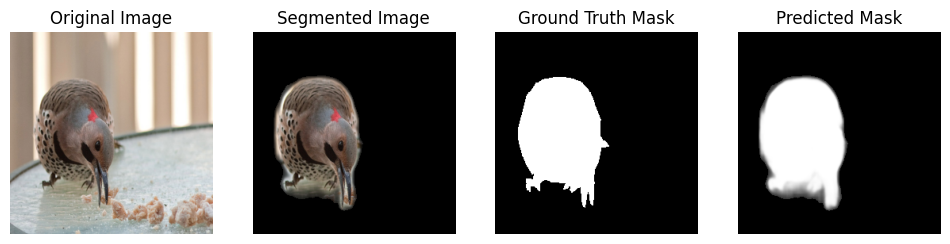

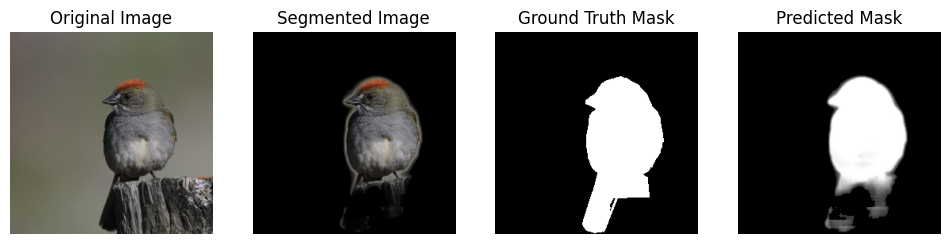

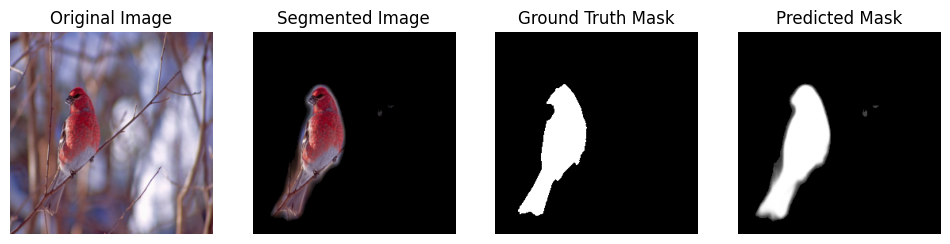

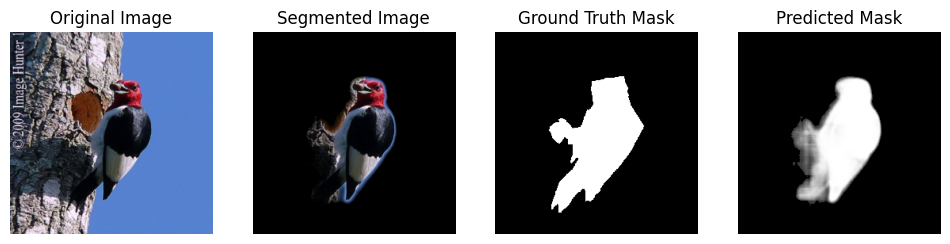

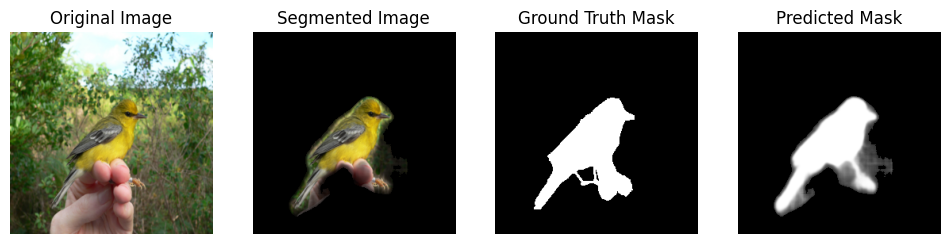

In [9]:
import numpy as np
model.eval()
with torch.no_grad():
    val_batch = next(iter(val_loader))
    x, y = val_batch
    x = x.to(device)
    y = y.to(device)
    
    outputs = model(x)
    outputs = torch.sigmoid(outputs)
    outputs = outputs.cpu()
    
    for idx in range(5):
        img = x[idx].cpu().permute(1,2,0).numpy()
        mask = y[idx].cpu().squeeze(0).numpy()
        pred = outputs[idx].squeeze(0).numpy()

        pred = pred * (pred >= 0.2).astype(int)
        _3d_pred = np.stack([pred, pred, pred], axis=-1)
        seg_img = img * _3d_pred
        
        fig, ax = plt.subplots(1, 4, figsize=(12, 4))
        ax[0].imshow(img)
        ax[0].set_title('Original Image')
        ax[0].axis('off')

        ax[1].imshow(seg_img)
        ax[1].set_title('Segmented Image')
        ax[1].axis('off')
        
        ax[2].imshow(mask, cmap='gray')
        ax[2].set_title('Ground Truth Mask')
        ax[2].axis('off')
        
        ax[3].imshow(pred, cmap='gray')
        ax[3].set_title('Predicted Mask')
        ax[3].axis('off')
        
        plt.show()

In [ ]:
torch.save(model.state_dict(), 'model.pth')

In [ ]:
model = UNet(in_channels=3, out_channels=1).to(device)
model.load_state_dict(torch.load('model.pth'))

/tmp/ipykernel_30/1447087007.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('unet_model.pth'))


<All keys matched successfully>